In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv("dataset.csv")


In [3]:
# features(X) / target(y) 분리
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [4]:
#  training/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
#  CatBoost ensemble uncertainty 함수 정의
def catboost_ensemble_uncertainty(
    X_train, y_train, X_test,
    seeds=[0,1,2,3,4],
    init_params=None,
    fit_params=None
):
    init_params = init_params or {}
    fit_params  = fit_params  or {}

    all_preds = []
    for seed in seeds:
        model = CatBoostRegressor(
            random_seed=seed,
            **init_params
        )
        model.fit(
            X_train, y_train,
            **fit_params
        )
        preds = model.predict(X_test)
        all_preds.append(preds)

    all_preds = np.stack(all_preds, axis=0)
    mean_preds = all_preds.mean(axis=0)
    std_preds  = all_preds.std(axis=0)
    return mean_preds, std_preds


In [6]:
# hyperparameter 및 seed 설정
init_params = {
    "iterations": 500,
    "learning_rate": 0.1,
    "depth": 6
}
fit_params = {
    "verbose": False
}
seeds = [0, 1, 2, 3, 4]  # 앙상블 크기 = 5


In [7]:

#  호출 및 결과 출력
mean_cb, std_cb = catboost_ensemble_uncertainty(
    X_train, y_train, X_test,
    seeds=seeds,
    init_params=init_params,
    fit_params=fit_params
)


In [8]:

# 예측값과 불확실성 확인 (첫 10개 샘플)
for i in range(10):
    print(f"샘플 {i:2d}: 예측={mean_cb[i]:.3f}, 불확실성(std)={std_cb[i]:.3f}")


샘플  0: 예측=52.603, 불확실성(std)=0.300
샘플  1: 예측=43.694, 불확실성(std)=0.168
샘플  2: 예측=74.515, 불확실성(std)=0.865
샘플  3: 예측=33.635, 불확실성(std)=0.144
샘플  4: 예측=11.011, 불확실성(std)=0.322
샘플  5: 예측=46.266, 불확실성(std)=0.505
샘플  6: 예측=25.165, 불확실성(std)=0.656
샘플  7: 예측=48.006, 불확실성(std)=0.494
샘플  8: 예측=34.917, 불확실성(std)=0.389
샘플  9: 예측=45.250, 불확실성(std)=0.326


In [10]:
# 요약 통계 출력 (모델 전체의 불확실성 평가)
print(f"테스트 샘플 수       : {len(std_cb)}")
print(f"평균 불확실성        : {std_cb.mean():.3f}")
print(f"중앙값 불확실성       : {np.median(std_cb):.3f}")
print(f"최소 불확실성        : {std_cb.min():.3f}")
print(f"최대 불확실성        : {std_cb.max():.3f}")

테스트 샘플 수       : 206
평균 불확실성        : 0.539
중앙값 불확실성       : 0.463
최소 불확실성        : 0.077
최대 불확실성        : 2.483


C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from c

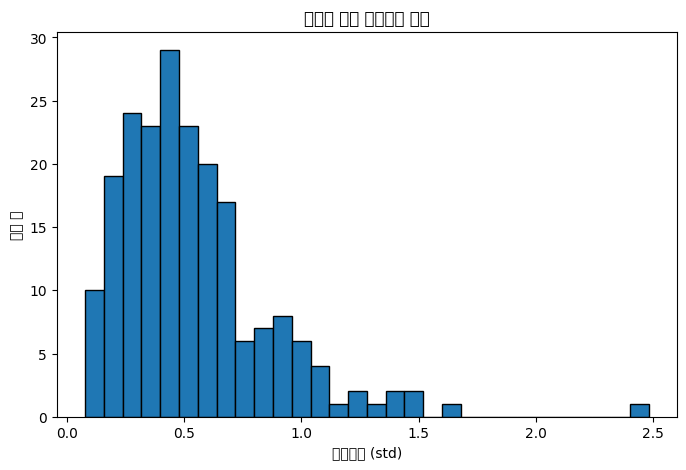

In [11]:
# 히스토그램으로 분포 시각화하기
plt.figure(figsize=(8, 5))
plt.hist(std_cb, bins=30, edgecolor='k')
plt.xlabel("불확실성 (std)")
plt.ylabel("샘플 수")
plt.title("테스트 세트 불확실성 분포")
plt.show()